# AI-VAR 1D for various background functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# reproducibility
np_rng = np.random.default_rng(7)
torch.manual_seed(7)

device = torch.device("cpu")
dtype  = torch.float64   # important for stability with B^{-1}


B shape: (256, 256)
diag(B): 0.0625
cond(B): 573425.1573160174


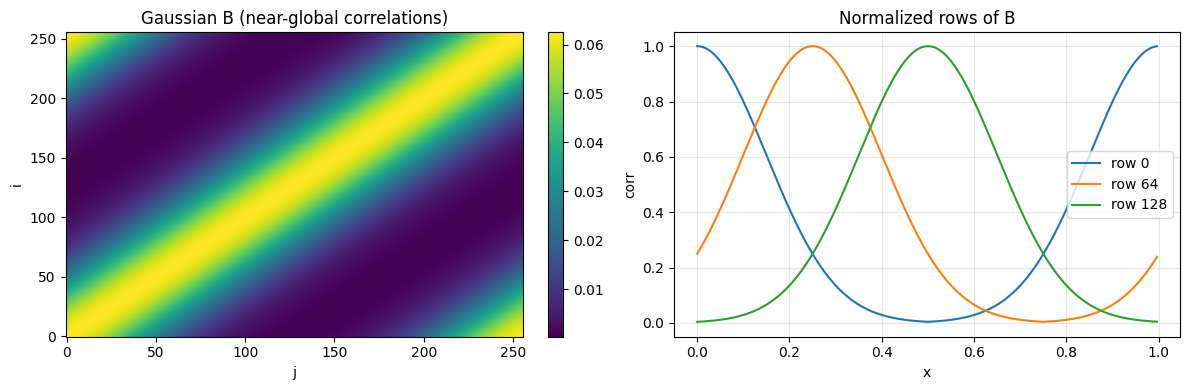

B_inv symmetry error: 0.0


In [2]:
# ----------------------------
# 1D periodic grid
# ----------------------------
n = 256
x_grid = np.linspace(0.0, 1.0, n, endpoint=False)
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Grid (reuse x_grid, n from cell 1)
# -------------------------------------------------
# assumes:
#   x_grid : shape (n,)
#   n      : int

# -------------------------------------------------
# B-matrix parameters
# -------------------------------------------------
sigma_b = 0.25
L = 0.15     # correlation length

# -------------------------------------------------
# Periodic distance matrix
# -------------------------------------------------
X_i = x_grid[:, None]
X_j = x_grid[None, :]

dist = np.abs(X_i - X_j)
dist = np.minimum(dist, 1.0 - dist)   # periodic distance

# -------------------------------------------------
# Gaussian covariance
# -------------------------------------------------
B = (sigma_b**2) * np.exp(-(dist**2) / (2 * L**2))

# -------------------------------------------------
# Diagnostics
# -------------------------------------------------
print("B shape:", B.shape)
print("diag(B):", B.diagonal()[0])
print("cond(B):", np.linalg.cond(B))

# -------------------------------------------------
# Visualization
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- full matrix ---
im = axes[0].imshow(
    B,
    origin="lower",
    aspect="auto",
    cmap="viridis"
)
axes[0].set_title("Gaussian B (near-global correlations)")
axes[0].set_xlabel("j")
axes[0].set_ylabel("i")
plt.colorbar(im, ax=axes[0], fraction=0.046)

# --- normalized rows ---
rows = [0, n // 4, n // 2]
for r in rows:
    axes[1].plot(
        x_grid,
        B[r] / B[r, r],
        label=f"row {r}"
    )

axes[1].set_title("Normalized rows of B")
axes[1].set_xlabel("x")
axes[1].set_ylabel("corr")
axes[1].set_ylim(-0.05, 1.05)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# ----------------------------
# Background covariance B (Gaussian, periodic)
# ----------------------------
sigma_b = 0.25
L = 0.15

X_i = x_grid[:, None]
X_j = x_grid[None, :]
dist = np.abs(X_i - X_j)
dist = np.minimum(dist, 1.0 - dist)

B = (sigma_b**2) * np.exp(-(dist**2) / (2 * L**2))
B = 0.5 * (B + B.T)  # enforce symmetry

# ----------------------------
# Spectral regularization for B^{-1}
# ----------------------------
alpha = 5e-4  # eigenvalue floor relative to max eigenvalue
lam, U = np.linalg.eigh(B)
lam_floor = alpha * lam.max()
lam_reg = np.maximum(lam, lam_floor)

B_inv = (U * (1.0 / lam_reg)) @ U.T
B_inv = 0.5 * (B_inv + B_inv.T)

print("B_inv symmetry error:", np.linalg.norm(B_inv - B_inv.T) / np.linalg.norm(B_inv))

# torch
B_inv_t = torch.tensor(B_inv, dtype=dtype, device=device)


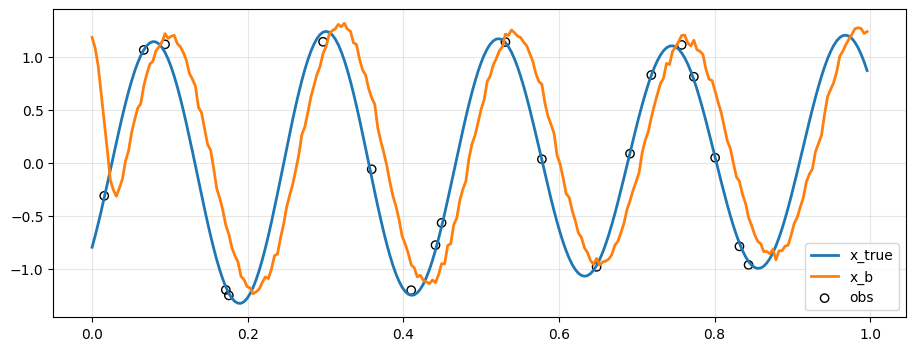

In [3]:
def smooth_periodic(x, sigma_pts=2.0):
    radius = int(np.ceil(4*sigma_pts))
    t = np.arange(-radius, radius+1)
    ker = np.exp(-(t**2)/(2*sigma_pts**2))
    ker /= ker.sum()
    x_pad = np.r_[x[-radius:], x, x[:radius]]
    return np.convolve(x_pad, ker, mode="same")[radius:-radius]

def sample_case(n, x_grid, m_obs=20, obs_sigma=0.05, rng=None):
    rng = np.random.default_rng() if rng is None else rng

    # truth: modulated sine with random parameters
    k = rng.uniform(2.0, 6.0)
    phase = rng.uniform(0.0, 2*np.pi)
    A0 = rng.uniform(0.7, 1.3)
    A1 = rng.uniform(0.0, 0.5)
    A_mod_k = rng.uniform(0.5, 2.0)
    trend_amp = rng.uniform(-0.25, 0.25)

    A = A0 + A1 * np.sin(2*np.pi*A_mod_k*x_grid + rng.uniform(0, 2*np.pi))
    trend = trend_amp * (x_grid - 0.5)
    x_true = A * np.sin(2*np.pi*k*x_grid + phase) + trend

    # background: shifted + smoothed + bias + noise
    shift = int(rng.integers(0, 12))
    bias  = rng.uniform(-0.15, 0.15)
    sigma_pts = rng.uniform(1.0, 3.5)

    xb = np.roll(x_true, shift)
    xb = smooth_periodic(xb, sigma_pts=sigma_pts)
    xb = xb + bias + 0.03 * rng.standard_normal(n)

    # obs at random indices
    obs_idx = np.sort(rng.choice(n, size=m_obs, replace=False))
    y = x_true[obs_idx] + obs_sigma * rng.standard_normal(m_obs)

    # obs-on-grid encoding
    y_grid = np.zeros(n, dtype=float)
    mask   = np.zeros(n, dtype=float)
    y_grid[obs_idx] = y
    mask[obs_idx]   = 1.0

    return x_true, xb, y_grid, mask, obs_idx

# quick test plot
x_true, xb, y_grid, mask, obs_idx = sample_case(n, x_grid, rng=np_rng)
plt.figure(figsize=(11,4))
plt.plot(x_grid, x_true, lw=2, label="x_true")
plt.plot(x_grid, xb, lw=2, label="x_b")
plt.scatter(x_grid[obs_idx], y_grid[obs_idx], facecolors="none", edgecolors="k", label="obs")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


In [4]:
# -------------------------------------------------
# Observation error standard deviation (global)
# -------------------------------------------------
obs_sigma = 0.01

# -------------------------------------------------
# AI-VAR / 3D-Var loss over a batch (no explicit H)
# -------------------------------------------------
def J_3dvar_batch(delta_x, xb, y_grid, mask):
    """
    delta_x, xb, y_grid, mask: tensors of shape (B, n)
    """
    # analysis
    x = xb + delta_x

    # background term: 0.5 * dx^T B^{-1} dx
    Binv_dx = delta_x @ B_inv_t.T          # (B, n)
    Jb = 0.5 * torch.sum(delta_x * Binv_dx, dim=-1)

    # observation term: only at obs points (mask == 1)
    innov = (x - y_grid) * mask
    Jo = 0.5 * torch.sum((innov / obs_sigma)**2, dim=-1)

    # batch mean
    J  = torch.mean(Jb + Jo)
    return J, torch.mean(Jb), torch.mean(Jo)


In [5]:
class IncrementMLP(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3*n, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, n),
        )

    def forward(self, xb, y_grid, mask):
        inp = torch.cat([xb, y_grid, mask], dim=-1)  # (B, 3n)
        return self.net(inp)                         # (B, n)

model = IncrementMLP(n).to(device).to(dtype)


In [6]:
class IncrementMLP(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3*n, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, n),
        )

    def forward(self, xb, y_grid, mask):
        inp = torch.cat([xb, y_grid, mask], dim=-1)  # (B, 3n)
        return self.net(inp)                         # (B, n)

model = IncrementMLP(n).to(device).to(dtype)


In [7]:
import time
import numpy as np
import torch
import torch.optim as optim

# -------------------------------------------------
# Optimizer and training setup
# -------------------------------------------------
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 64
n_epochs   = 2000
log_every  = 100

loss_hist = []

# -------------------------------------------------
# Timing
# -------------------------------------------------
t_start = time.time()

# -------------------------------------------------
# Training loop
# -------------------------------------------------
for ep in range(1, n_epochs + 1):

    # ----------------------------
    # Build random batch
    # ----------------------------
    xb_list, ygrid_list, mask_list = [], [], []
    for _ in range(batch_size):
        x_true, xb, y_grid, mask, obs_idx = sample_case(
            n, x_grid, m_obs=20, obs_sigma=obs_sigma, rng=np_rng
        )
        xb_list.append(xb)
        ygrid_list.append(y_grid)
        mask_list.append(mask)

    xb_b    = torch.tensor(np.stack(xb_list),    dtype=dtype, device=device)
    ygrid_b = torch.tensor(np.stack(ygrid_list), dtype=dtype, device=device)
    mask_b  = torch.tensor(np.stack(mask_list),  dtype=dtype, device=device)

    # ----------------------------
    # Optimization step
    # ----------------------------
    optimizer.zero_grad()
    delta = model(xb_b, ygrid_b, mask_b)
    J, Jb, Jo = J_3dvar_batch(delta, xb_b, ygrid_b, mask_b)
    J.backward()
    optimizer.step()

    loss_hist.append(float(J.detach().cpu()))

    # ----------------------------
    # Logging with ETA
    # ----------------------------
    if ep % log_every == 0 or ep == 1:
        t_now = time.time()
        elapsed = t_now - t_start
        rate = elapsed / ep
        remaining = rate * (n_epochs - ep)

        print(
            f"ep {ep:4d}/{n_epochs} | "
            f"J={float(J):.3e} | Jb={float(Jb):.3e} | Jo={float(Jo):.3e} | "
            f"elapsed={elapsed/60:6.1f} min | "
            f"ETA={remaining/60:6.1f} min"
        )

# -------------------------------------------------
# Done
# -------------------------------------------------
total_time = time.time() - t_start
print(f"\nTraining finished in {total_time/60:.1f} minutes.")


/var/folders/4d/v62x5gg540g5q0n2_dmlyd60000c0j/T/ipykernel_61724/192014547.py:65: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  f"J={float(J):.3e} | Jb={float(Jb):.3e} | Jo={float(Jo):.3e} | "


ep    1/2000 | J=2.598e+04 | Jb=1.631e+02 | Jo=2.581e+04 | elapsed=   0.0 min | ETA=   0.8 min
ep  100/2000 | J=8.292e+03 | Jb=2.136e+03 | Jo=6.157e+03 | elapsed=   0.0 min | ETA=   0.1 min
ep  200/2000 | J=9.616e+03 | Jb=2.604e+03 | Jo=7.011e+03 | elapsed=   0.0 min | ETA=   0.1 min
ep  300/2000 | J=6.520e+03 | Jb=2.508e+03 | Jo=4.012e+03 | elapsed=   0.0 min | ETA=   0.1 min
ep  400/2000 | J=8.621e+03 | Jb=2.585e+03 | Jo=6.035e+03 | elapsed=   0.0 min | ETA=   0.1 min
ep  500/2000 | J=6.783e+03 | Jb=2.317e+03 | Jo=4.466e+03 | elapsed=   0.0 min | ETA=   0.1 min
ep  600/2000 | J=7.308e+03 | Jb=2.468e+03 | Jo=4.840e+03 | elapsed=   0.0 min | ETA=   0.1 min
ep  700/2000 | J=8.631e+03 | Jb=3.347e+03 | Jo=5.284e+03 | elapsed=   0.1 min | ETA=   0.1 min
ep  800/2000 | J=7.037e+03 | Jb=2.699e+03 | Jo=4.337e+03 | elapsed=   0.1 min | ETA=   0.1 min
ep  900/2000 | J=7.302e+03 | Jb=2.638e+03 | Jo=4.664e+03 | elapsed=   0.1 min | ETA=   0.1 min
ep 1000/2000 | J=6.279e+03 | Jb=2.536e+03 | Jo=3.7

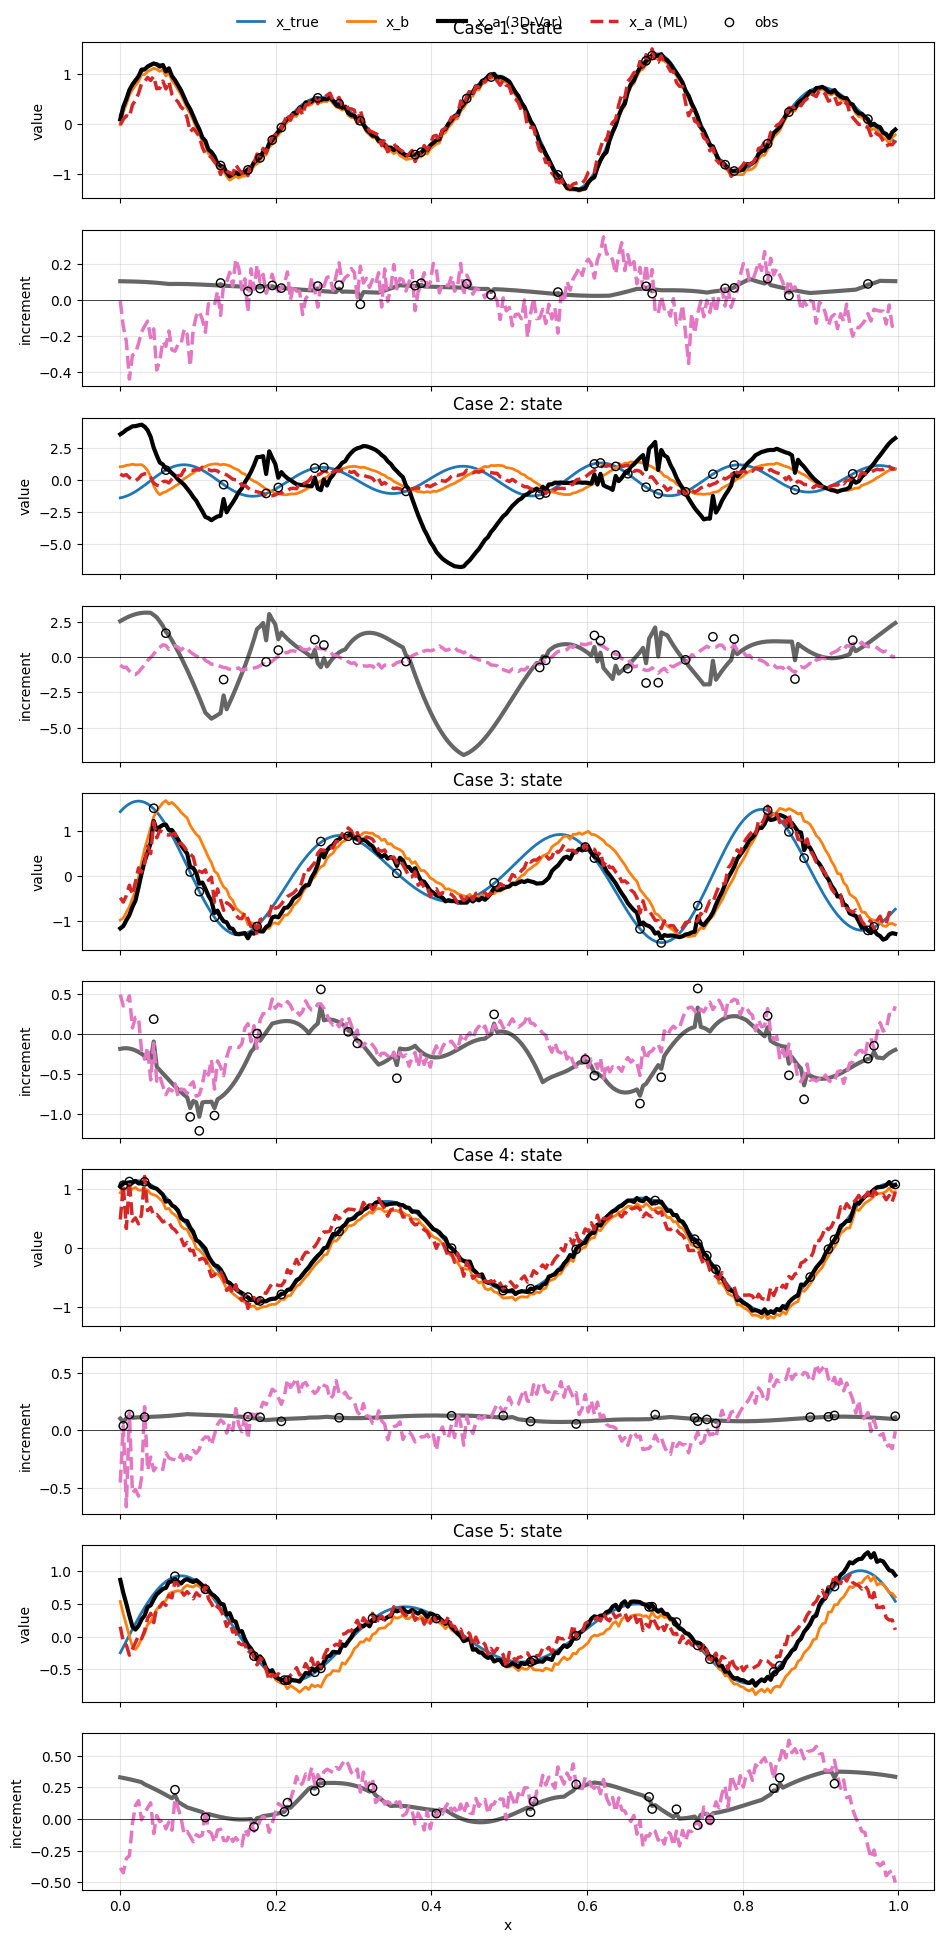

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# =================================================
# Settings
# =================================================
alpha   = 1e-4
N_cases = 5

# =================================================
# Color scheme (state vs increment)
# =================================================
c_true = "tab:blue"
c_xb   = "tab:orange"
c_3dv  = "black"
c_ml   = "tab:red"

c_3dv_inc = "0.4"        # dark gray (related to black)
c_ml_inc  = "tab:pink"   # lighter red tone

# =================================================
# Prepare figure
# =================================================
fig, axes = plt.subplots(
    2 * N_cases, 1,
    figsize=(11, 2.4 * 2 * N_cases),
    sharex=True
)

# =================================================
# Loop over cases
# =================================================
for k in range(N_cases):

    # -----------------------------
    # Sample fresh test case
    # -----------------------------
    x_true, xb, y_grid, mask, obs_idx = sample_case(
        n, x_grid, m_obs=20, obs_sigma=obs_sigma, rng=np_rng
    )

    # -----------------------------
    # ML analysis
    # -----------------------------
    xb_t    = torch.tensor(xb[None, :],     dtype=dtype, device=device)
    ygrid_t = torch.tensor(y_grid[None, :], dtype=dtype, device=device)
    mask_t  = torch.tensor(mask[None, :],   dtype=dtype, device=device)

    with torch.no_grad():
        delta_ml = model(xb_t, ygrid_t, mask_t).cpu().numpy().squeeze()

    xa_ml = xb + delta_ml

    # -----------------------------
    # 3D-Var (consistent B + αI)
    # -----------------------------
    B_alpha = B + alpha * np.eye(n)

    m = obs_idx.size
    R = (obs_sigma**2) * np.eye(m)

    H = np.zeros((m, n))
    for j, i in enumerate(obs_idx):
        H[j, i] = 1.0

    y_vec = y_grid[obs_idx]
    d = y_vec - H @ xb
    S = H @ B_alpha @ H.T + R

    xa_3d = xb + B_alpha @ H.T @ np.linalg.solve(S, d)

    # -----------------------------
    # Increments
    # -----------------------------
    inc_ml  = xa_ml - xb
    inc_3dv = xa_3d - xb
    inc_obs = y_vec - xb[obs_idx]

    # =================================================
    # Plot: STATE
    # =================================================
    ax0 = axes[2 * k]

    ax0.plot(x_grid, x_true, lw=2,   color=c_true)
    ax0.plot(x_grid, xb,     lw=2,   color=c_xb)
    ax0.plot(x_grid, xa_3d,  lw=3,   color=c_3dv)
    ax0.plot(x_grid, xa_ml,  "--", lw=2.5, color=c_ml)

    ax0.scatter(
        x_grid[obs_idx], y_vec,
        facecolors="none", edgecolors="k",
        zorder=6
    )

    ax0.set_ylabel("value")
    ax0.set_title(f"Case {k+1}: state")
    ax0.grid(True, alpha=0.3)

    # Legend only once
    if k == 0:
        ax0.legend(
            [
                "x_true",
                "x_b",
                "x_a (3D-Var)",
                "x_a (ML)",
                "obs"
            ],
            loc="upper center",
            ncol=5,
            frameon=False,
            bbox_to_anchor=(0.5, 1.25)
        )

    # =================================================
    # Plot: INCREMENT
    # =================================================
    ax1 = axes[2 * k + 1]

    ax1.plot(x_grid, inc_3dv, lw=3,   color=c_3dv_inc)
    ax1.plot(x_grid, inc_ml,  "--", lw=2.5, color=c_ml_inc)

    ax1.scatter(
        x_grid[obs_idx], inc_obs,
        facecolors="none", edgecolors="k",
        zorder=6
    )

    ax1.axhline(0.0, color="k", lw=0.5)
    ax1.set_ylabel("increment")
    ax1.grid(True, alpha=0.3)

# =================================================
# Final layout
# =================================================
axes[-1].set_xlabel("x")

plt.savefig("1d_multiple_rec.png")
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# =================================================
# Plot and save individual reconstructions
# =================================================
for k in range(N_cases):

    # -----------------------------
    # Sample fresh test case
    # -----------------------------
    x_true, xb, y_grid, mask, obs_idx = sample_case(
        n, x_grid, m_obs=20, obs_sigma=obs_sigma, rng=np_rng
    )

    # -----------------------------
    # ML analysis
    # -----------------------------
    xb_t    = torch.tensor(xb[None, :],     dtype=dtype, device=device)
    ygrid_t = torch.tensor(y_grid[None, :], dtype=dtype, device=device)
    mask_t  = torch.tensor(mask[None, :],   dtype=dtype, device=device)

    with torch.no_grad():
        delta_ml = model(xb_t, ygrid_t, mask_t).cpu().numpy().squeeze()

    xa_ml = xb + delta_ml

    # -----------------------------
    # 3D-Var analysis
    # -----------------------------
    B_alpha = B + alpha * np.eye(n)

    m = obs_idx.size
    R = (obs_sigma**2) * np.eye(m)

    H = np.zeros((m, n))
    for j, i in enumerate(obs_idx):
        H[j, i] = 1.0

    y_vec = y_grid[obs_idx]
    d = y_vec - H @ xb
    S = H @ B_alpha @ H.T + R

    xa_3d = xb + B_alpha @ H.T @ np.linalg.solve(S, d)

    # =================================================
    # Plot: reconstruction only
    # =================================================
    fig, ax = plt.subplots(1, 1, figsize=(11, 3.5))

    ax.plot(x_grid, x_true, lw=2.5, color=c_true, label="x_true")
    ax.plot(x_grid, xb,     lw=2.0, color=c_xb,   label="x_b")
    ax.plot(x_grid, xa_3d,  lw=3.0, color=c_3dv,  label="x_a (3D-Var)")
    ax.plot(x_grid, xa_ml,  "--", lw=2.5, color=c_ml, label="x_a (ML)")

    ax.scatter(
        x_grid[obs_idx], y_vec,
        facecolors="none", edgecolors="k",
        zorder=6, label="obs"
    )

    ax.set_title(f"1D reconstruction — case {k+1}")
    ax.set_xlabel("x")
    ax.set_ylabel("value")
    ax.grid(True, alpha=0.3)

    ax.legend(
        loc="upper center",
        ncol=5,
        frameon=False,
        bbox_to_anchor=(0.5, 1.25)
    )

    # -----------------------------
    # Save
    # -----------------------------
    fname = f"1d_multiple_{k+1:02d}.png"
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close(fig)

    print(f"saved {fname}")


saved 1d_multiple_01.png
saved 1d_multiple_02.png
saved 1d_multiple_03.png
saved 1d_multiple_04.png
saved 1d_multiple_05.png


run  10/ 10 | RMSE_ML=2.440e-01 | RMSE_3DVar=3.385e-01 | Δ=-9.45e-02 | run=  3.4s | elapsed=  0.6m | ETA=  0.0m

Summary:
ML:    mean RMSE = 0.24430791061107876  std = 0.00398177383560388
3DVar: mean RMSE = 0.3384624870382878  std = 0.0
Total wall time: 0.6 minutes
(Using alpha=0.0001 via B_alpha = B + alpha I)


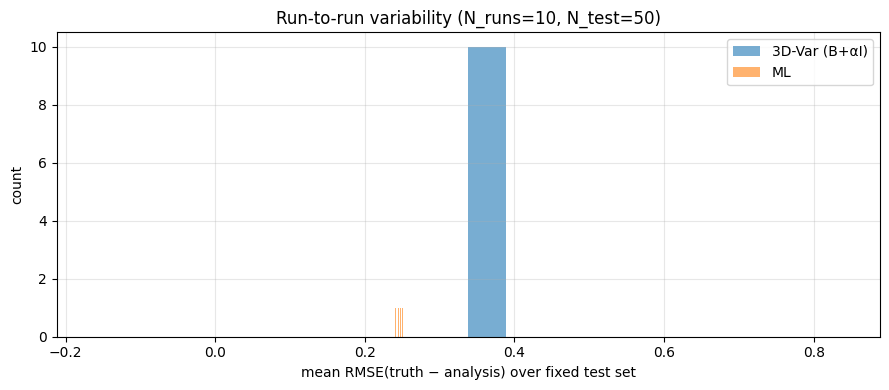

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import time

# ============================================================
# Settings
# ============================================================
alpha      = 1e-4        # <-- NEW: match ML regularization (B + alpha I)
N_runs     = 10
N_test     = 50
m_obs_test = 20

batch_size = 64
n_epochs   = 800
lr         = 1e-3
log_every  = 0

# ============================================================
# Precompute B_alpha once (consistent with ML)
# ============================================================
B_alpha = B + alpha * np.eye(n)

# ============================================================
# 1) Create and freeze test set ONCE
# ============================================================
test_cases = []
for _ in range(N_test):
    x_true, xb, y_grid, mask, obs_idx = sample_case(
        n, x_grid, m_obs=m_obs_test, obs_sigma=obs_sigma, rng=np_rng
    )
    test_cases.append((x_true, xb, y_grid, mask, obs_idx))

def solve_3dvar_closed_form_alpha(xb, y_grid, obs_idx):
    """Closed-form 3D-Var for point sampling obs, using B_alpha = B + alpha I."""
    m = obs_idx.size
    obs_sigma2=3*obs_sigma
    R = (obs_sigma2**2) * np.eye(m)

    H = np.zeros((m, n))
    for k, i in enumerate(obs_idx):
        H[k, i] = 1.0

    y_vec = y_grid[obs_idx]
    d = y_vec - H @ xb
    S = H @ B_alpha @ H.T + R
    return xb + B_alpha @ H.T @ np.linalg.solve(S, d)

def rmse(a):
    return float(np.sqrt(np.mean(a * a)))

# ============================================================
# 2) One training run
# ============================================================
def train_one_model(seed: int):
    torch.manual_seed(seed)
    local_rng = np.random.default_rng(seed)

    model = IncrementMLP(n).to(device).to(dtype)
    opt = optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, n_epochs + 1):
        xb_list, ygrid_list, mask_list = [], [], []
        for _ in range(batch_size):
            x_true, xb, y_grid, mask, obs_idx = sample_case(
                n, x_grid, m_obs=m_obs_test, obs_sigma=obs_sigma, rng=local_rng
            )
            xb_list.append(xb)
            ygrid_list.append(y_grid)
            mask_list.append(mask)

        xb_b    = torch.tensor(np.stack(xb_list),    dtype=dtype, device=device)
        ygrid_b = torch.tensor(np.stack(ygrid_list), dtype=dtype, device=device)
        mask_b  = torch.tensor(np.stack(mask_list),  dtype=dtype, device=device)

        opt.zero_grad()
        delta = model(xb_b, ygrid_b, mask_b)
        J, Jb, Jo = J_3dvar_batch(delta, xb_b, ygrid_b, mask_b)
        J.backward()
        opt.step()

        if log_every and (ep == 1 or ep % log_every == 0):
            print(f"[seed {seed}] ep {ep:4d} | J={float(J):.3e} | Jb={float(Jb):.3e} | Jo={float(Jo):.3e}")

    return model

# ============================================================
# 3) Run N trainings with timing
# ============================================================
rmse_ml_runs = []
rmse_3d_runs = []

t_global_start = time.time()

for k in range(N_runs):
    t_run_start = time.time()

    seed = 1000 + k
    model = train_one_model(seed)

    errs_ml = []
    errs_3d = []

    for (x_true, xb, y_grid, mask, obs_idx) in test_cases:
        xb_t    = torch.tensor(xb[None, :],     dtype=dtype, device=device)
        ygrid_t = torch.tensor(y_grid[None, :], dtype=dtype, device=device)
        mask_t  = torch.tensor(mask[None, :],   dtype=dtype, device=device)

        with torch.no_grad():
            delta_ml = model(xb_t, ygrid_t, mask_t).cpu().numpy().squeeze()
        xa_ml = xb + delta_ml

        # 3D-Var (now consistent with alpha)
        xa_3d = solve_3dvar_closed_form_alpha(xb, y_grid, obs_idx)

        errs_ml.append(rmse(x_true - xa_ml))
        errs_3d.append(rmse(x_true - xa_3d))

    rmse_ml_runs.append(float(np.mean(errs_ml)))
    rmse_3d_runs.append(float(np.mean(errs_3d)))

    # Timing + progress
    t_run = time.time() - t_run_start
    t_elapsed = time.time() - t_global_start
    t_avg = t_elapsed / (k + 1)
    t_remain = t_avg * (N_runs - k - 1)

    print(
        f"run {k+1:3d}/{N_runs:3d} | "
        f"RMSE_ML={rmse_ml_runs[-1]:.3e} | "
        f"RMSE_3DVar={rmse_3d_runs[-1]:.3e} | "
        f"Δ={(rmse_ml_runs[-1] - rmse_3d_runs[-1]):+.2e} | "
        f"run={t_run:5.1f}s | "
        f"elapsed={t_elapsed/60:5.1f}m | "
        f"ETA={t_remain/60:5.1f}m",
        end="\r",
        flush=True
    )

print()  # newline after progress loop

# ============================================================
# 4) Summary statistics
# ============================================================
rmse_ml_runs = np.array(rmse_ml_runs)
rmse_3d_runs = np.array(rmse_3d_runs)

print("\nSummary:")
print("ML:    mean RMSE =", rmse_ml_runs.mean(), " std =", rmse_ml_runs.std())
print("3DVar: mean RMSE =", rmse_3d_runs.mean(), " std =", rmse_3d_runs.std())
print(f"Total wall time: {(time.time()-t_global_start)/60:.1f} minutes")
print(f"(Using alpha={alpha:g} via B_alpha = B + alpha I)")

# ============================================================
# 5) Histogram
# ============================================================
plt.figure(figsize=(9,4))
plt.hist(rmse_3d_runs, bins=20, alpha=0.6, label="3D-Var (B+αI)")
plt.hist(rmse_ml_runs, bins=20, alpha=0.6, label="ML")
plt.xlabel("mean RMSE(truth − analysis) over fixed test set")
plt.ylabel("count")
plt.title(f"Run-to-run variability (N_runs={N_runs}, N_test={N_test})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
